# U-Net for Image Segmentation

This notebook illustrates how to build a [UNet](https://arxiv.org/abs/1505.04597) for semantic image segmentation. This architecture is also a fully convolutional network. A key thing to note is the use of skip connections from the encoder to the decoder.

UNet can be used to output segmentation masks that shows which pixels of an input image are part of the background, foreground, and outline.

<img src='https://drive.google.com/uc?export=view&id=1w8up90xVOYRT8vs5lNo2kEiVhm-7hWxZ' alt='sample_output'>

# Imports

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

## Download the Oxford-IIIT Pets dataset

We will be training our model using the [Oxford Pets - IIT dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), which includes pet images along with their classes, segmentation masks, and head region-of-interest annotations. For this lab, we will focus on utilizing the images and segmentation masks.

This dataset is conveniently available through TensorFlow Datasets, allowing for easy access and integration into our training process. By downloading this dataset directly within TensorFlow, we ensure that we have the correct versions that include the necessary segmentation masks (available in versions 3 and above).

Once downloaded, the dataset will be stored in a dictionary named `dataset`, facilitating easy access to different subsets such as training and validation data. Additionally, we will gather detailed information about the dataset and store it in a variable named `info`. This information will help us understand the structure of the dataset, including details about the classes, image sizes, and format of the segmentation masks, which is crucial for correctly configuring our model and training process.

In [ ]:
# Ensure there are no problems with checksums
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=oxford_iiit_pet:3.1.0

# download the dataset and get info
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_datasets/scripts/download_and_prepare.py", line 25, in <module>
    from tensorflow_datasets.scripts.cli import main as main_cli
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_datasets/scripts/cli/main.py", line 37, in <module>
    from tensorflow_datasets.scripts.cli import convert_format
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_datasets/scripts/cli/convert_format.py", line 32, in <module>
    from tensorflow_datasets.scripts.cli import convert_format_utils
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_datasets/scripts/cli/convert_format_utils.py", line 169, in <module>
    pipeline: beam.Pipeline | None = None,
  File "/usr/local/lib/python3.10/

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.22Q6K7_3.2.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.22Q6K7_3.2.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


We'll take a moment to explore the contents of the Oxford Pets - IIT dataset that we've just downloaded. This step is crucial to understand the structure and components of our dataset, ensuring that we are familiar with the types of data available and how they are organized. Knowing this will assist us in effectively utilizing the dataset for training our model, particularly focusing on how the images are aligned with their corresponding segmentation masks.

In [ ]:
# Print the possible keys we can access in the dataset dict. This contains the test and train splits.
print(dataset.keys())

dict_keys(['train', 'test'])


In [ ]:
# Print information about the dataset
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir=PosixGPath('/tmp/tmpw4doyzf9tfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        '

## Prepare the Dataset

We are now set to prepare the train and test sets for our model, which involves a series of preprocessing steps to ensure the data is suitable for training. These steps are designed to optimize the model's performance and handle the unique characteristics of the segmentation masks provided in the dataset.

**Preprocessing Steps for the Images:**
1. **Image Augmentation**: We will perform simple augmentation techniques such as flipping the images horizontally. This step helps increase the diversity of our training data, allowing the model to learn more robust features and reduce overfitting.
  
2. **Normalization**: Normalizing the pixel values of the images is essential. We'll adjust the pixel values so they range between 0 and 1 (or -1 and 1, depending on the model architecture). This normalization helps speed up the training by ensuring that the model deals with smaller, more uniform values.

3. **Resizing**: All images will be resized to a consistent dimension. This uniformity is crucial for batching the images during training and ensures that the input layer of our neural network receives data in a consistent format.

**Adjusting the Segmentation Masks:**
- According to the dataset’s annotations README, the pixel values in the segmentation masks are labeled as 1 for foreground (pet), 2 for background, and 3 for not classified (outline). For our model's convenience and to align with typical categorical cross-entropy expectations, we will subtract 1 from each pixel value in the segmentation masks. This adjustment shifts the labels to 0 (pet), 1 (background), and 2 (outline).

**Rationale for Adjusting Mask Values:**
- This shift simplifies the process of using these masks with loss functions that expect classes to start from 0. It also makes the interpretation of the model's outputs more straightforward during training and evaluation.

These preprocessing steps will ensure that both the input images and the segmentation masks are optimally prepared for effective training of our segmentation model, facilitating accurate and efficient learning.

In [ ]:
# Preprocessing Utilities

def random_flip(input_image, input_mask):
  '''Does a random flip of the image and mask'''
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  return input_image, input_mask


def normalize(input_image, input_mask):
  '''
  Normalizes the input image pixel values to be from [0,1].
  Subtracts 1 from the mask labels to have a range from [0,2]
  '''
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask


@tf.function
def load_image_train(datapoint):
  '''Resizes, normalizes, and flips the training data'''
  input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
  input_image, input_mask = random_flip(input_image, input_mask)
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask


def load_image_test(datapoint):
  '''Resizes and normalizes the test data'''
  input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

We can now use the utility functions we discussed earlier to prepare the train and test datasets. The dataset from TensorFlow Datasets already provides these splits, so we'll simply access them using the 'train' and 'test' keys from the dataset dictionary.

We'll apply the preprocessing transformations to both datasets, ensuring they're properly augmented, normalized, resized, and the segmentation masks are adjusted. This is done to ensure our model receives data that is consistent and well-suited for effective training.

Additionally, we'll use TensorFlow's AUTOTUNE feature to optimize the data pipeline. This feature dynamically adjusts processing parameters like the number of parallel operations based on available system resources, ensuring efficient data processing without manual tuning. This helps streamline model training and maximizes performance across different hardware setups.

In [ ]:
# Preprocess the train and test sets
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

We'll access the train and test splits from the dataset dictionary for preprocessing and use TensorFlow's AUTOTUNE to optimize data handling based on our system's capabilities. This ensures efficient preparation of the data for training and evaluation.

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

# Shuffle and group the train set into batches
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# Prefetch training dataset to optimize processing
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Group the test set into batches
test_dataset = test.batch(BATCH_SIZE)

We'll set up additional utilities to enhance our ability to visualize the data and assess the performance metrics effectively. These tools will be crucial for observing how well our model segments the images and for making any necessary adjustments to improve its accuracy.

In [ ]:
# Class list of the mask pixels
class_names = ['pet', 'background', 'outline']


def display_with_metrics(display_list, iou_list, dice_score_list):
  '''Displays a list of images/masks and overlays a list of IOU and Dice Scores'''

  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place

  display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n\n".join(display_string_list)

  display(display_list, ["Image", "Predicted Mask", "True Mask"], display_string=display_string)


def display(display_list,titles=[], display_string=None):
  '''Displays a list of images/masks'''

  plt.figure(figsize=(15, 15))

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    if display_string and i == 1:
      plt.xlabel(display_string, fontsize=12)
    img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
    plt.imshow(img_arr)

  plt.show()


def show_image_from_dataset(dataset):
  '''Displays the first image and its mask from a dataset'''

  for image, mask in dataset.take(1):
    sample_image, sample_mask = image, mask
  display([sample_image, sample_mask], titles=["Image", "True Mask"])


def plot_metrics(metric_name, title, ylim=5):
  '''Plots a given metric from the model history'''
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(model_history.history[metric_name],color='blue',label=metric_name)
  plt.plot(model_history.history['val_' + metric_name],color='green',label='val_' + metric_name)

We can now examine an example image and its corresponding mask from the dataset to visually assess the quality of the data and the effectiveness of our preprocessing steps. This helps ensure that our model is receiving the correct inputs for training.

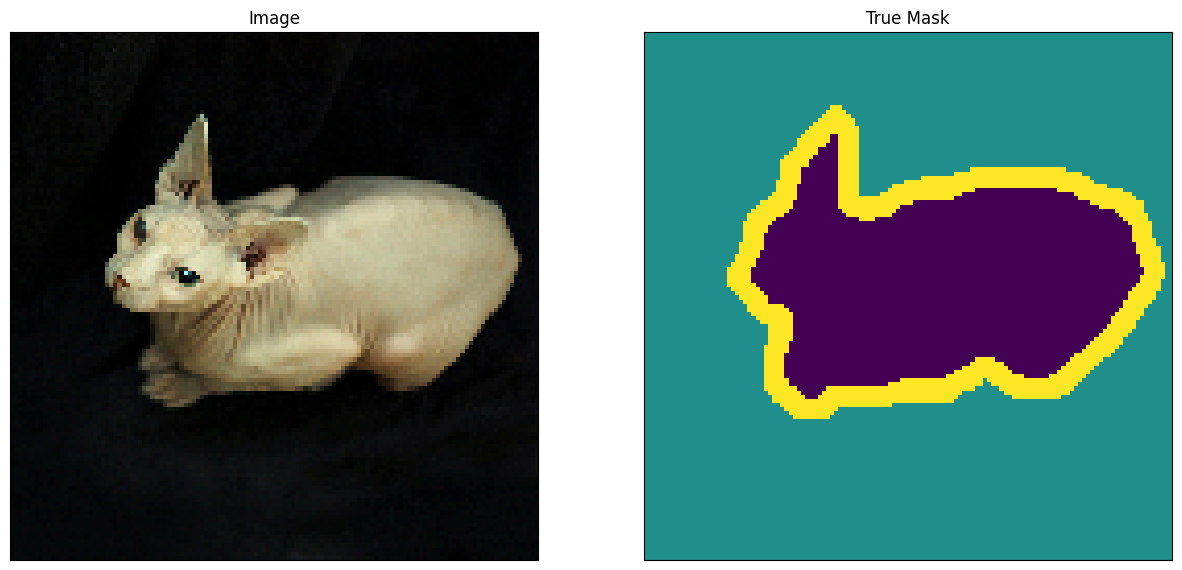

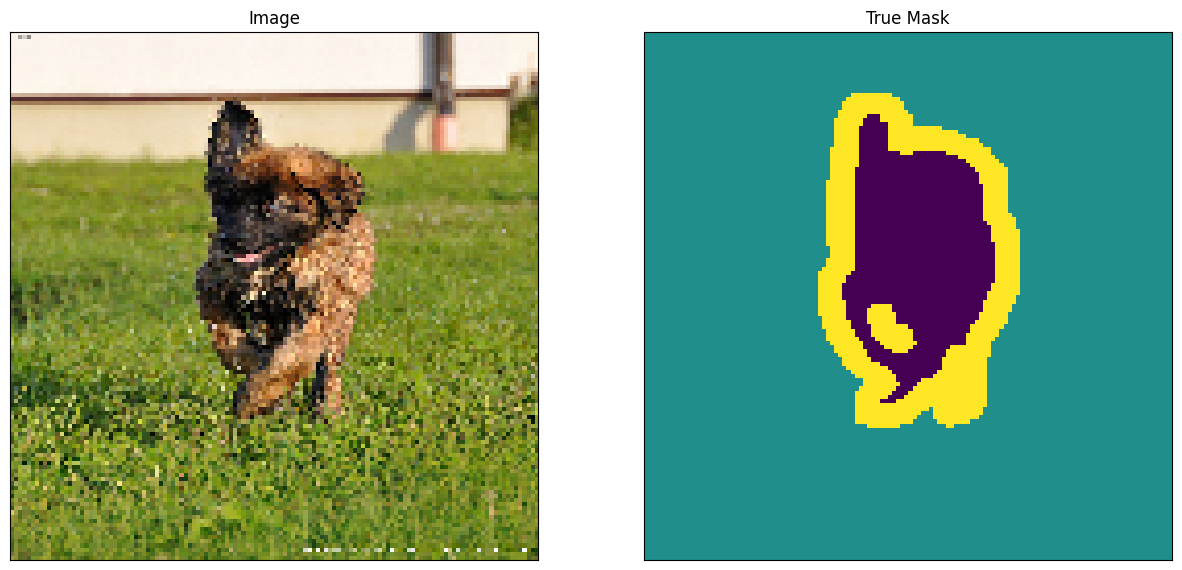

In [ ]:
# Display an image from the train set
show_image_from_dataset(train)

# Display an image from the test set
show_image_from_dataset(test)

## Define the model

With our dataset ready, we can proceed to construct the UNet model. The UNet architecture is particularly effective for segmentation tasks due to its encoder-decoder structure with skip connections that help preserve spatial hierarchies for precise localization. The image below shows the UNet model architecture

<img src='https://drive.google.com/uc?export=view&id=1BeQSKL2Eq6Fw9iRXsN1hgunY-CS2nH7V' alt='unet'>

**Overview of the UNet Architecture:**
- **Encoder (Downsampler):** The encoder progressively reduces the spatial dimensions of the input image while increasing the feature depth. This part of the network extracts and condenses the essential features from the input.
  
- **Bottleneck:** This component sits between the encoder and decoder. It processes the most compressed feature representation, ensuring that the most critical features are extracted for the decoding process.
  
- **Decoder (Upsampler):** The decoder progressively reconstructs the feature map to the original image size. It uses the features extracted by the encoder and bottleneck, along with additional context provided via skip connections from the encoder layers.
  
- **Skip Connections:** These are crucial for the UNet architecture. They help recover spatial information lost during downsampling by concatenating features from the encoder to the corresponding decoder layers. This process aids in precise localization and detailed segmentation.

The visual representation from class illustrates how these components are structured and interact within the UNet, providing a clear map for building the model. Starting with the encoder, we'll carefully implement each part to ensure our model effectively learns to segment the images from our prepared dataset.

### Encoder

In building our UNet model, similar to the FCN model from our previous session, we'll start by designing the encoder. The encoder will consist of repeating blocks, as highlighted in red in the class diagram. Creating functions for these blocks will make our code modular and easier to manage, ensuring each block is consistently applied throughout the encoder.

**Key Components of Each Encoder Block:**
- **Convolutional Layers**: Each block will contain two Conv2D layers, each followed by a ReLU activation function. These layers are responsible for extracting features at various levels of abstraction.
  
- **MaxPooling Layer**: Follows the convolutional layers and serves to reduce the spatial dimensions of the feature maps. This reduction helps in minimizing computational requirements and also helps the model to capture more abstract features by enlarging the receptive field of the following layers.
  
- **Dropout Layer**: Applied after the pooling layer to prevent overfitting by randomly dropping units during training, which forces the network to learn more robust features that are not reliant on specific pathways.

**Progressive Increase in Filters**:
- As we progress deeper into the encoder, the number of filters in the Conv2D layers increases. This increase allows the network to handle more complex features as the spatial complexity decreases due to pooling.

By structuring our encoder in this way, we ensure that it effectively compresses the input image into a rich feature representation, capturing essential information at various scales. This setup is crucial for the subsequent decoding process, where these features will be used to reconstruct the segmentation map accurately.

<img src='https://drive.google.com/uc?export=view&id=1Gs9K3_8ZBn2_ntOtJL_-_ww4ZOgfyhrS' alt='unet'>

For constructing the encoder of our UNet model, we will define three utility functions to maintain clarity and modularity in our code. Each function serves a specific purpose, aligning with the structured approach of the UNet architecture.

**Detailed Breakdown of the Encoder Utilities:**

1. **`conv2d_block()`**:
   - **Purpose**: This function will add two convolutional layers, each followed by a ReLU activation. It's designed to extract features at each block level.
   - **Output**: The output of this function will be the feature map after the second convolutional layer, which will carry the high-level features extracted from the input data at that stage.

2. **`encoder_block()`**:
   - **Purpose**: Builds on the `conv2d_block()` by adding a MaxPooling layer to reduce the spatial dimensions and a Dropout layer to reduce overfitting. This function is crucial for down-sampling the feature maps while maintaining important features.
   - **Output**: Since UNet requires feature maps from different levels for the skip connections, this function will return two outputs: the output from the `conv2d_block()` before pooling (to be used in skip connections) and the output after the Dropout layer (to be fed into the next encoder or bottleneck).

3. **`encoder()`**:
   - **Purpose**: Constructs the entire encoder by sequentially connecting multiple `encoder_block()` instances, progressively increasing the number of filters and decreasing the spatial dimensions of the feature maps.
   - **Output**: This function will return the final output of the last encoder block and a collection of outputs from all previous `conv2d_block()` within each `encoder_block()`. These collected outputs are essential for establishing skip connections to the decoder blocks, which help the network to better localize and delineate object boundaries in the segmentation maps.

By organizing our encoder construction into these functions, we ensure that each part is clearly defined and easily adjustable. This modularity not only aids in debugging and maintenance but also simplifies the process of experimenting with different architectures or configurations to improve model performance.

In [ ]:
# Encoder

def conv2d_block(input_tensor, n_filters, kernel_size = 3):
  '''
  Adds 2 convolutional layers with the parameters passed to it

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    tensor of output features
  '''
  # first layer
  x = input_tensor
  for i in range(2):
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)

  return x


def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
  '''
  Adds two convolutional blocks and then perform down sampling on output of convolutions.

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    f - the output features of the convolution block
    p - the maxpooled features with dropout
  '''

  f = conv2d_block(inputs, n_filters=n_filters)
  p = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(f)
  p = tf.keras.layers.Dropout(0.3)(p)

  return f, p


def encoder(inputs):
  '''
  This function defines the encoder or downsampling path.

  Args:
    inputs (tensor) -- batch of input images

  Returns:
    p4 - the output maxpooled features of the last encoder block
    (f1, f2, f3, f4) - the output features of all the encoder blocks
  '''
  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)

  return p4, (f1, f2, f3, f4)

### Bottleneck

Following the encoder, the UNet architecture incorporates a bottleneck, which serves as a crucial component situated between the encoder and decoder. The primary function of the bottleneck is to process and further refine the features extracted by the encoder, capturing the most essential information before the upsampling process begins in the decoder.

**Key Characteristics of the Bottleneck:**

- **No Pooling Layer**: Unlike the encoder blocks, the bottleneck does not include a pooling layer. This design choice ensures that the spatial dimensions of the feature maps are preserved, maintaining the resolution of the data as it passes through this critical stage of the network.

- **Feature Extraction**: The bottleneck continues to extract features by applying additional convolutional layers. It deepens the feature extraction without reducing the size of the feature maps, preparing the model for the precise upscaling needed in the decoder.

**Implementation Using `conv2d_block()`:**
- Since the bottleneck essentially involves applying more convolutional layers to the data, we can efficiently implement it using the `conv2d_block()` function already defined for the encoder blocks. This function will apply two consecutive convolutional layers with ReLU activations, which is consistent with the rest of the architecture and ensures that the features are processed thoroughly.

Using the `conv2d_block()` in this way keeps our code modular and consistent, leveraging the same function to handle similar operations across different parts of the network. This not only simplifies the model building process but also maintains clarity and ease of modification or expansion in future iterations of the model design.

In [ ]:
def bottleneck(inputs):
  '''
  This function defines the bottleneck convolutions to extract more features before the upsampling layers.
  '''

  bottle_neck = conv2d_block(inputs, n_filters=1024)

  return bottle_neck

### Decoder

The final segment of our UNet architecture is the decoder, where the feature maps produced by the encoder and processed through the bottleneck are upsampled back to the original image size. This step is crucial for reconstructing the detailed segmentation map from the compressed feature representations.

**Key Process in the Decoder:**

1. **Upsampling**: The decoder progressively increases the spatial dimensions of the feature maps. This process involves several upsampling steps, each of which enlarges the feature maps to gradually approach the original dimensions of the input image.

2. **Skip Connections**: A critical feature of the UNet decoder is the use of skip connections. These connections take the outputs from each corresponding encoder block (prior to pooling), which contain higher-resolution feature information, and concatenate them with the upsampled outputs at each level of the decoder. This method helps reintroduce finer details back into the feature maps, aiding in more precise localization and definition in the segmentation map.

3. **Concatenation Before Further Processing**: At each stage of the decoder, before feeding the upsampled features into the next decoder block, the feature map is concatenated with the output from the corresponding encoder block. This combination ensures that the decoder leverages both the abstracted features processed through the network and the finer details captured earlier by the encoder.

**Visual Representation**: The described process effectively reconstructs the segmentation maps by merging deep, semantic information from the bottleneck and detailed spatial information from the encoder. This strategy ensures that the final output segmentation maps closely align with the true boundaries and classes present in the original images, providing high-quality segmentation results.

This structured approach to decoding, characterized by layer-by-layer upsampling combined with strategic reintroduction of earlier features, is what enables UNet to excel in tasks requiring precise delineation of complex objects in images.

<img src='https://drive.google.com/uc?export=view&id=1Ql5vdw6l88vxaHgk7VjcMc4vfyoWYx2w' alt='unet_decoder'>

In [ ]:
def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
  '''
  defines the one decoder block of the UNet

  Args:
    inputs (tensor) -- batch of input features
    conv_output (tensor) -- features from an encoder block
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size
    strides (int) -- strides for the deconvolution/upsampling
    padding (string) -- "same" or "valid", tells if shape will be preserved by zero padding

  Returns:
    c (tensor) -- output features of the decoder block
  '''
  u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters, kernel_size=3)

  return c


def decoder(inputs, convs, output_channels):
  '''
  Defines the decoder of the UNet chaining together 4 decoder blocks.

  Args:
    inputs (tensor) -- batch of input features
    convs (tuple) -- features from the encoder blocks
    output_channels (int) -- number of classes in the label map

  Returns:
    outputs (tensor) -- the pixel wise label map of the image
  '''

  f1, f2, f3, f4 = convs

  c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='softmax')(c9)

  return outputs

### Putting it all together

To complete our UNet model, we integrate the encoder, bottleneck, and decoder components into a cohesive architecture. This integration allows for a seamless flow of feature maps through each stage, ensuring effective feature extraction, processing, and reconstruction to form the final segmentation map.

**Building the UNet:**

1. **Encoder**: The encoder part of the UNet compresses the input image into a series of feature maps, reducing the spatial dimensions while increasing the depth of features at each stage. These feature maps contain compressed spatial information of the input images.

2. **Bottleneck**: Situated between the encoder and decoder, the bottleneck further processes these features, utilizing additional convolutional layers to extract the most essential attributes without altering the spatial dimensions.

3. **Decoder**: The decoder then progressively reconstructs the spatial dimensions of the input image. It uses upsampling techniques combined with features reintroduced from the encoder through skip connections to ensure that both high-level semantic information and low-level details are utilized to accurately reconstruct the segmentation map.

4. **Final Layer**: The output of the decoder is then passed through a final convolutional layer that adjusts the depth of the feature maps to the number of desired output channels. For this specific dataset, where each pixel is classified as 'pet', 'background', or 'outline', the final output of the UNet will have three channels corresponding to these classes.

**Configuring Output Channels**:
- The last layer of the UNet, which directly forms the predicted segmentation map, will have a convolutional layer with three filters. This setup ensures that the model’s output has three channels, each representing one of the possible labels for each pixel.

By carefully assembling these components, we ensure that our UNet is well-suited for the task at hand—producing precise and accurate segmentation maps that differentiate between pets, background, and outlines. This structure not only leverages the strengths of the UNet architecture but is also specifically adapted to the requirements of our segmentation task.

In [ ]:
OUTPUT_CHANNELS = 3

def unet():
  '''
  Defines the UNet by connecting the encoder, bottleneck and decoder.
  '''

  # Specify the input shape
  inputs = tf.keras.layers.Input(shape=(128, 128,3,))

  # Feed the inputs to the encoder
  encoder_output, convs = encoder(inputs)

  # Feed the encoder output to the bottleneck
  bottle_neck = bottleneck(encoder_output)

  # Feed the bottleneck and encoder block outputs to the decoder while specifing the number of classes via the `output_channels` argument
  outputs = decoder(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)

  # Create the model
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

# Instantiate the model
model = unet()

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 128, 128, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['activation[0][0]']          
                                                                                              

## Compile and Train the model

With the UNet architecture fully assembled, the next steps are to compile and train the model, crucial phases that will define how well our model learns to perform pixel-wise classification for image segmentation.

**Compiling the Model:**
- **Loss Function**: We'll use `sparse_categorical_crossentropy` for the loss function. This choice is particularly suited for segmentation tasks where each pixel is classified into one of several classes. The "sparse" aspect of this loss function allows us to use the ground truth labels as integers (e.g., 0 for 'pet', 1 for 'background', 2 for 'outline'), which simplifies the handling of segmentation masks where each pixel is labeled with a single integer.
  
- **Optimizer**: A robust optimizer like Adam or SGD will be employed to minimize the loss function. Adam is often preferred due to its adaptive learning rate capabilities, which can lead to faster convergence, especially in complex networks like UNet.

- **Metrics**: Besides the loss, accuracy or other relevant metrics such as IoU (Intersection over Union) can be tracked to monitor the performance during training. These metrics provide insights into how well the model is segmenting different classes.

**Training the Model**:
- Training involves feeding the input images and corresponding true segmentation masks to the model, allowing it to learn from the errors it makes initially, and gradually improving its predictions through backpropagation. Training will continue for a predefined number of epochs or until a certain performance threshold is met.

By efficiently compiling and setting up the training process, we ensure that our UNet model learns to accurately predict the class of each pixel in the image, effectively segmenting the image into 'pet', 'background', and 'outline'. This setup, centered around the sparse categorical cross-entropy, aligns well with the nature of our task and the format of our data.

In [ ]:
# Configure the optimizer, loss and metrics for training
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Configure the training parameters and train the model
TRAIN_LENGTH = info.splits['train'].num_examples
EPOCHS = 10
VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

# Train the model
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)

Epoch 1/10
57/57 [==============================] - 117s 993ms/step - loss: 0.9190 - accuracy: 0.5885 - val_loss: 0.8771 - val_accuracy: 0.5733
Epoch 2/10
57/57 [==============================] - 77s 966ms/step - loss: 0.7582 - accuracy: 0.6876 - val_loss: 0.6922 - val_accuracy: 0.7202
Epoch 3/10
57/57 [==============================] - 55s 967ms/step - loss: 0.6576 - accuracy: 0.7317 - val_loss: 0.6044 - val_accuracy: 0.7559
Epoch 4/10
57/57 [==============================] - 55s 963ms/step - loss: 0.5915 - accuracy: 0.7638 - val_loss: 0.5479 - val_accuracy: 0.7831
Epoch 5/10
57/57 [==============================] - 57s 1s/step - loss: 0.5380 - accuracy: 0.7883 - val_loss: 0.5008 - val_accuracy: 0.8021
Epoch 6/10
57/57 [==============================] - 55s 962ms/step - loss: 0.4808 - accuracy: 0.8127 - val_loss: 0.4589 - val_accuracy: 0.8234
Epoch 7/10
57/57 [==============================] - 55s 963ms/step - loss: 0.4431 - accuracy: 0.8282 - val_loss: 0.4368 - val_accuracy: 0.8298
E

We can graph the training and validation loss to monitor the model's progress. Typically, these values should decrease with each epoch, indicating effective learning.

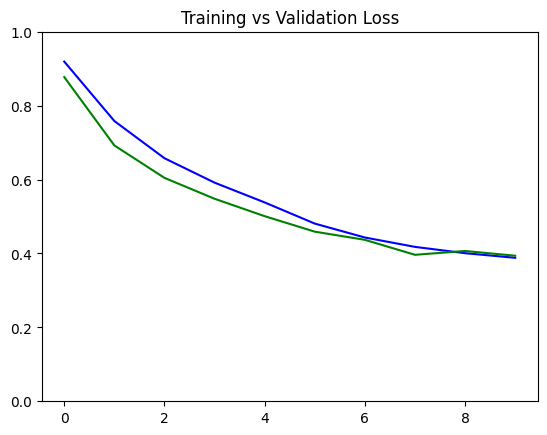

In [ ]:
# Plot the training and validation loss
plot_metrics("loss", title="Training vs Validation Loss", ylim=1)

## Make predictions

Our model is now ready to start making predictions. We'll utilize the test dataset, prepared earlier, to present the model with new images for evaluation. The utilities we've set up will assist in processing both the test data and the predictions from the model. This step is crucial for assessing the model's generalization capabilities on unseen data.

In [ ]:
# Prediction Utilities

def get_test_image_and_annotation_arrays():
  '''
  Unpacks the test dataset and returns the input images and segmentation masks
  '''

  ds = test_dataset.unbatch()
  ds = ds.batch(info.splits['test'].num_examples)

  images = []
  y_true_segments = []

  for image, annotation in ds.take(1):
    y_true_segments = annotation.numpy()
    images = image.numpy()

  y_true_segments = y_true_segments[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))]

  return images[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))], y_true_segments


def create_mask(pred_mask):
  '''
  Creates the segmentation mask by getting the channel with the highest probability. Remember that we
  have 3 channels in the output of the UNet. For each pixel, the predicition will be the channel with the
  highest probability.
  '''
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0].numpy()


def make_predictions(image, mask, num=1):
  '''
  Feeds an image to a model and returns the predicted mask.
  '''

  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

### Compute class wise metrics

Just like in the previous notebook, we'll also compute the Intersection over Union (IOU) and Dice Score to evaluate our model's performance. These metrics will help us understand how accurately the model segments different classes in the images.

In [ ]:
def class_wise_metrics(y_true, y_pred):
  class_wise_iou = []
  class_wise_dice_score = []

  smoothening_factor = 0.00001
  for i in range(3):

    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area

    iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
    class_wise_iou.append(iou)

    dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score

With all the necessary utilities set up, we're now ready to display metrics and test our model with actual images. This step will help us evaluate the model's performance and refine it further if needed.

In [ ]:
# Setup the ground truth and predictions.

# Get the ground truth from the test set
y_true_images, y_true_segments = get_test_image_and_annotation_arrays()

# Feed the test set to th emodel to get the predicted masks
results = model.predict(test_dataset, steps=info.splits['test'].num_examples//BATCH_SIZE)
results = np.argmax(results, axis=3)
results = results[..., tf.newaxis]

57/57 [==============================] - 15s 261ms/step


In [ ]:
# Compute the class wise metrics
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(y_true_segments, results)

In [ ]:
# Show the IOU for each class
for idx, iou in enumerate(cls_wise_iou):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, iou))

pet         0.7128307620113996 
background  0.8353312380370304 
outline     0.37485785768267865 


In [ ]:
# Show the Dice Score for each class
for idx, dice_score in enumerate(cls_wise_dice_score):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, dice_score))


pet         0.8323423163821403 
background  0.9102784508049663 
outline     0.5453041644825908 


### Show Predictions

1/1 [==============================] - 2s 2s/step


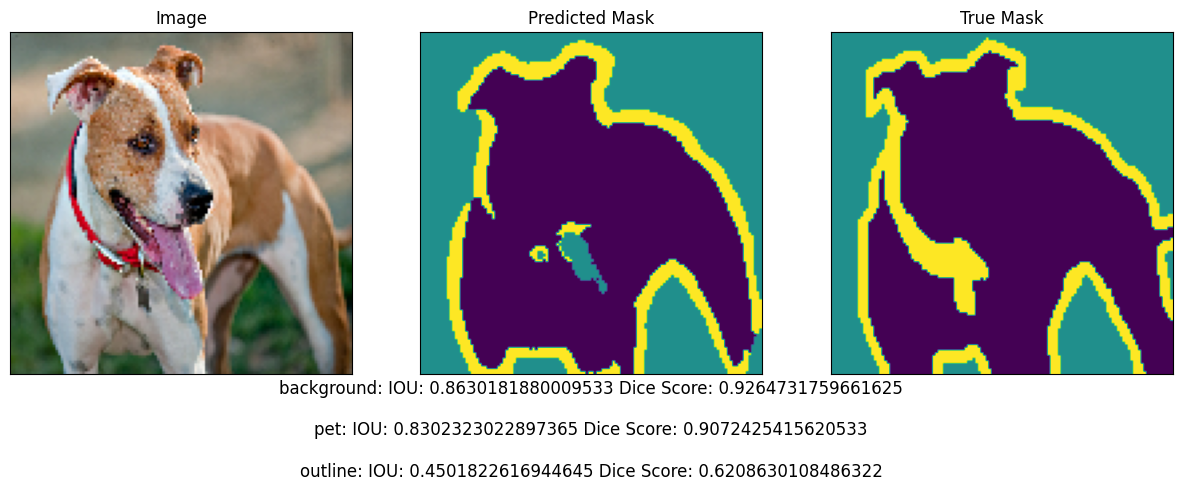

In [ ]:
# Please input a number between 0 to 3647 to pick an image from the dataset
integer_slider = 3646

# Get the prediction mask
y_pred_mask = make_predictions(y_true_images[integer_slider], y_true_segments[integer_slider])

# Compute the class wise metrics
iou, dice_score = class_wise_metrics(y_true_segments[integer_slider], y_pred_mask)

# Overlay the metrics with the images
display_with_metrics([y_true_images[integer_slider], y_pred_mask, y_true_segments[integer_slider]], iou, dice_score)